# Test visualization 

Visualizing the model test results.

Most of this notebook is based on [alexattia's kaggle kernel](https://www.kaggle.com/alexattia/visualizing-predicted-characters).

In [9]:
model_path = '../model/v1'
weights = '../model/v1/chcks/chck_30.h5'
testset_path = '../the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/'

In [10]:
import os, sys
sys.path.append(os.getcwd() + '/../source')
import logging
import argparse
import numpy as np
from model.vanilla import classification_model as cm
from sklearn.metrics import classification_report as class_report
from sklearn.metrics import confusion_matrix
from log import config_logger
from config import IN_SHAPE, IMSIZE
import glob
import cv2
from tensorflow.keras.utils import to_categorical
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

### Read labels

First of all, we need to read the model labels, the label on which the model trained on:

In [11]:
# read labels
with open(os.path.join(model_path, 'labels.txt'), 'r') as file:
    content = file.read()
    labels = content.split('\n')
    file.close()
print(f'Labels loaded succesfully - n_classes: {len(labels)}')

Labels loaded succesfully - n_classes: 31


### Load model

We create the model using the n_classes and config image size:

In [12]:
# create model
model = cm(input_shape=IN_SHAPE, class_num=len(labels))
model.load_weights(weights)

### Test set

Now we need to load the testset.
As our test data has less labels than what the model has trained on, we need to track these test labels.
We will need this data to create the classification report and the confusion matrix

In [13]:
def load_pic(pic_path):
    pic = cv2.imread(pic_path)
    pic = cv2.resize(pic, (IMSIZE, IMSIZE))
    return pic / 255

def X_load(x):
    x = np.array([load_pic(impath) for impath in x])
    return x

def y_load(y, labels):
    y = np.array([labels.index(l) for l in y])
    y = to_categorical(y, len(labels))
    return y

pics = glob.glob(os.path.join(testset_path, '*.*'))
pics = sorted(pics)
test_labels = ['_'.join(p.split('/')[-1].split('_')[:-1]) for p in pics]

# load test images and the categorical labels
X_test = X_load(pics)
y_test = y_load(test_labels, labels)

# as the number of test labels is not the same as the model labels
# (we have less labels than the dataset)
t_labels = np.unique(np.array([labels.index(i) for i in test_labels]))
t_names = np.unique(np.array(test_labels))

### Predict

Let's predict on our testset

In [14]:
y_pred = model.predict(np.array(X_test))
print(f'Test on: {len(t_names)} labels')

# get the test true labex index
# and the predictions argmax index
y_test_true = np.where(y_test > 0)[1]
y_pred_argmax = np.argmax(y_pred, axis=1)

Test on: 20 labels


### Results per file

Now we'll create a DataFrame to track the prediction result for every image tested:

In [15]:
test_images = sorted(os.listdir(testset_path))

results = 'image, prediction, score \n'
for i, image in enumerate(test_images):
    pred_label = labels[y_pred_argmax[i]]
    pred_score = max(y_pred[i])
    results += (f'\n {image}, {pred_label}, {pred_score:.2}\n')
    
result_data = StringIO(results)
results_df = pd.read_csv(result_data, sep=',')
results_df.head()

,image,prediction,score
0,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson,0.99
1,abraham_grampa_simpson_1.jpg,moe_szyslak,0.87
2,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson,1.00
3,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson,0.90
4,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson,1.00


### Classification report

Now we'll see the sklearn classification report to check the accuracy per class tested.

In [16]:
report = class_report(y_test_true,
                      y_pred_argmax,
                      labels=t_labels,
                      target_names=t_names,
                      zero_division=False)
print(report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.98      0.96        48
  apu_nahasapeemapetilon       1.00      0.98      0.99        50
            bart_simpson       1.00      0.94      0.97        49
charles_montgomery_burns       1.00      0.94      0.97        50
            chief_wiggum       1.00      1.00      1.00        47
          comic_book_guy       0.84      0.94      0.89        50
          edna_krabappel       0.96      0.92      0.94        50
           homer_simpson       0.96      0.98      0.97        49
           kent_brockman       0.94      0.96      0.95        48
        krusty_the_clown       0.96      0.96      0.96        50
           lenny_leonard       0.98      0.98      0.98        50
            lisa_simpson       0.94      0.98      0.96        50
           marge_simpson       1.00      0.96      0.98        49
            mayor_quimby       0.96      0.98      0.97        50
     milh

### Confusion matrix

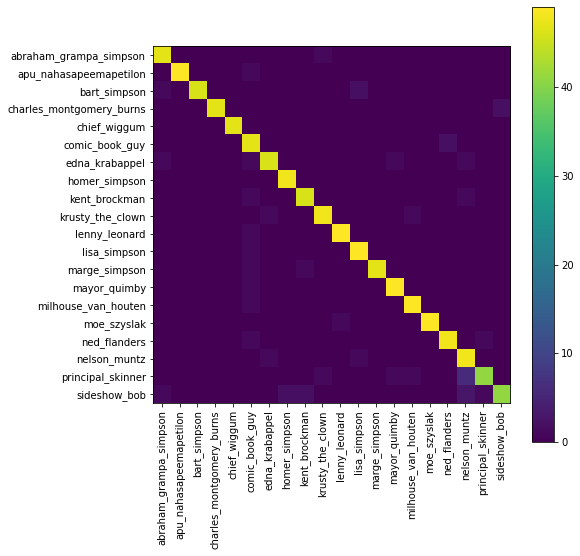

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
cnf_matrix = confusion_matrix(y_test_true, y_pred_argmax, labels=t_labels)
im = ax.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar(im)
tick_marks = np.arange(len(t_names))
_ = plt.xticks(tick_marks, t_names, rotation=90)
_ = plt.yticks(tick_marks, t_names)

As we can see, we have a little confusion, some of them are not okay:
- Skinner is confused with Nelson Muntz

But the general results are good.

### Visualizing

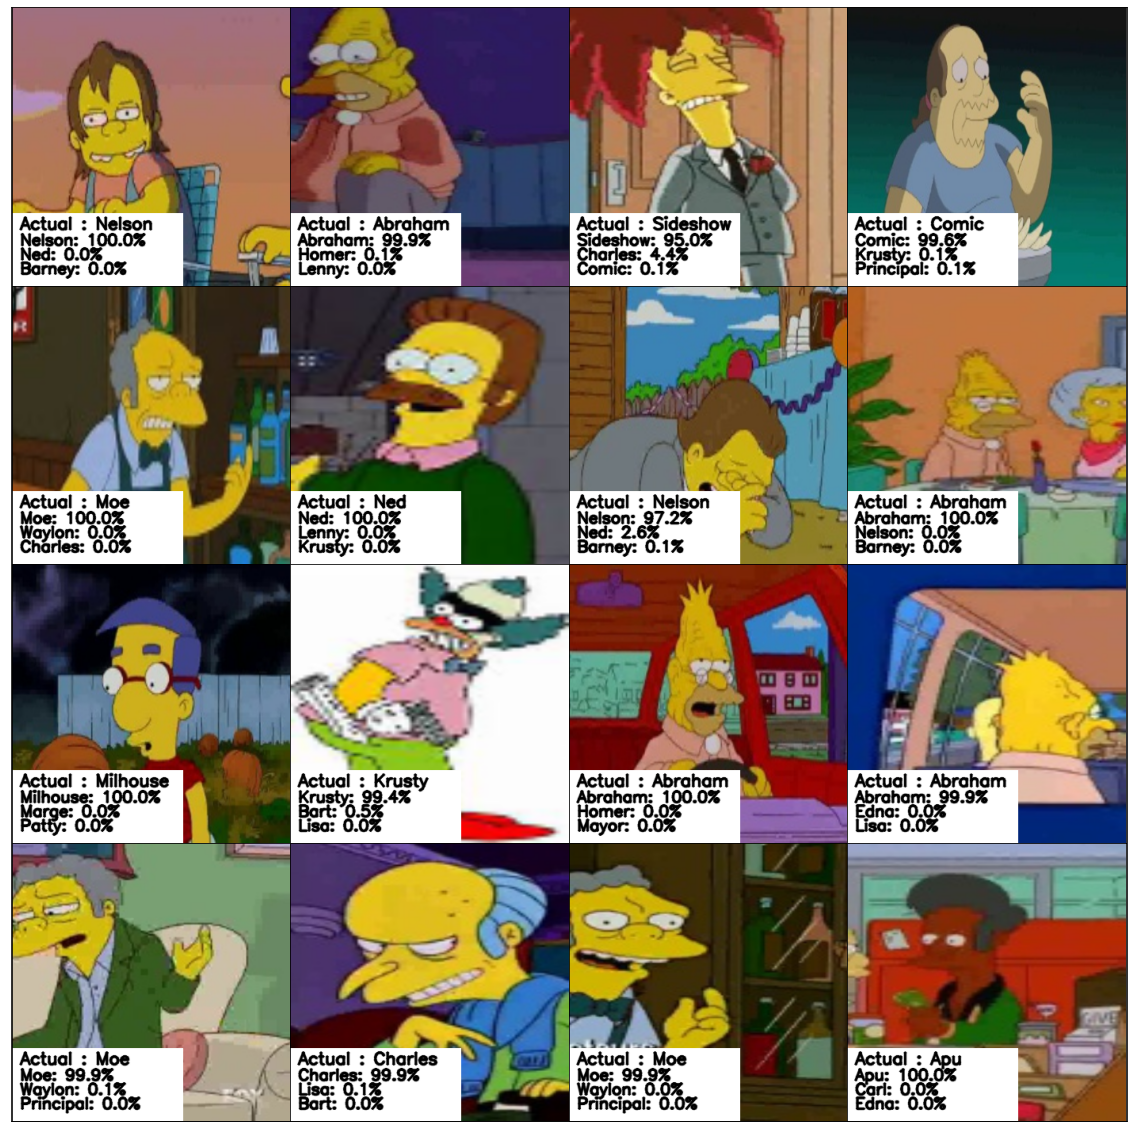

In [51]:
from mpl_toolkits.axes_grid1 import AxesGrid

F, ax = plt.subplots(figsize=(20, 20.5))
ax.grid(False)
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")
font = cv2.FONT_HERSHEY_SIMPLEX
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

def load_viz_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (352, 352))
    return image

for i in range(16):
    im_index = np.random.randint(0, len(test_images))
    image_name = test_images[im_index]
    image_path = os.path.join(testset_path, image_name)
    image = load_viz_image(image_path)
    
    # get real character name
    actual = image_name.split('_')[0].title()
    
    # get best three predictions
    best_preds = sorted(y_pred[im_index], reverse=True)[:3]
    labels_idxs = [list(y_pred[im_index]).index(p) for p in best_preds]
    best_labels = [labels[idx].split('_')[0].title() for idx in labels_idxs]
    best_preds_text = [f'{name}: {pred*100:.1f}%'
                        for name, pred in zip(best_labels, best_preds)]
    
    # show real and best predictions in image
    cv2.rectangle(image, (0, 260), (215, 352),
                  (255, 255, 255), -1)
    cv2.putText(image, 'Actual : %s' % actual,
                (10, 280), font,
                0.7, (0, 0, 0), 2, cv2.LINE_AA)
    for k, t in enumerate(best_preds_text):
        cv2.putText(image, t, (10, 300 + k*18),
                    font, 0.65, (0,0,0), 2, cv2.LINE_AA)
    
    grid[i].imshow(image)
    grid[i].set_xticks([])
    grid[i].set_yticks([])